In [1]:
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_curve, auc, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return f1, precision, recall, rmse, fpr, tpr, roc_auc

In [3]:
# Load the dataset provided in the image
dataset = pd.read_csv('../lib/data/fraction_preprocessed_data.csv', encoding='ISO-8859-1')
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset = dataset.dropna(subset=['Text'])
# dataset = dataset.sample(frac=0.1, random_state=42)
dataset

,Text,Source,Human
0,ING AsiaPacific Companys Problems Research Pap...,Human,1
1,Crisis Love Inquiry Essay Critical Writing fol...,Human,1
2,Sure sex segregation makes lot sense many spor...,Human,1
3,Christianity Islam Values Essay Christianity f...,Human,1
4,Becca liked swim practiced everyday hours ente...,GLM-130B,0
...,...,...,...
78887,Mass Eoghan Chada 10 brother Ruairi 5 said St ...,OPT-30B,0
78888,Asian Teachers Polish Lesson Perfection Stigle...,Human,1
78889,Move knife slowly avoid slipping accidentally ...,OPT-6.7B,0
78890,Good dreams likely occur person feeling relaxe...,Text-Davinci-003,0


In [4]:

# Split dataset into features and labels
X = dataset['Text']
y = dataset['Human']

In [5]:
# Load the logistic regression model
with open('../lib/models/Supervised/logistic_regression_model.pkl', 'rb') as file:
    logistic_regression_model = joblib.load(file)

In [6]:
# Load
tfidf = joblib.load('../lib/models/Supervised/Variables/log_tfidf_vectorizer.pkl')
scaler = joblib.load('../lib/models/Supervised/Variables/log_scaler.pkl')

In [8]:

X_train = joblib.load('../lib/models/Supervised/Variables/X_train.pkl')
X_test = joblib.load('../lib/models/Supervised/Variables/X_test.pkl')
y_train = joblib.load('../lib/models/Supervised/Variables/y_train.pkl')
y_test = joblib.load('../lib/models/Supervised/Variables/y_test.pkl')

In [9]:
# Standardize the data for neural networks
# scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
y_pred_logistic = logistic_regression_model.predict(X_test_scaled)

In [11]:
f1_logistic, precision_logistic, recall_logistic, rmse_logistic, fpr_logistic, tpr_logistic, auc_logistic = calculate_metrics(y_test, y_pred_logistic)


In [12]:
print("Logistic Regression: F1 Score =", f1_logistic, "Precision =", precision_logistic, "Recall =", recall_logistic, "RMSE =", rmse_logistic, "AUC =", auc_logistic)


Logistic Regression: F1 Score = 0.7917284212012139 Precision = 0.7781631520532741 Recall = 0.8057750323229421 RMSE = 0.43245892723674006 AUC = 0.8122206982889376


In [13]:
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      8818
           1       0.78      0.81      0.79      6961

    accuracy                           0.81     15779
   macro avg       0.81      0.81      0.81     15779
weighted avg       0.81      0.81      0.81     15779



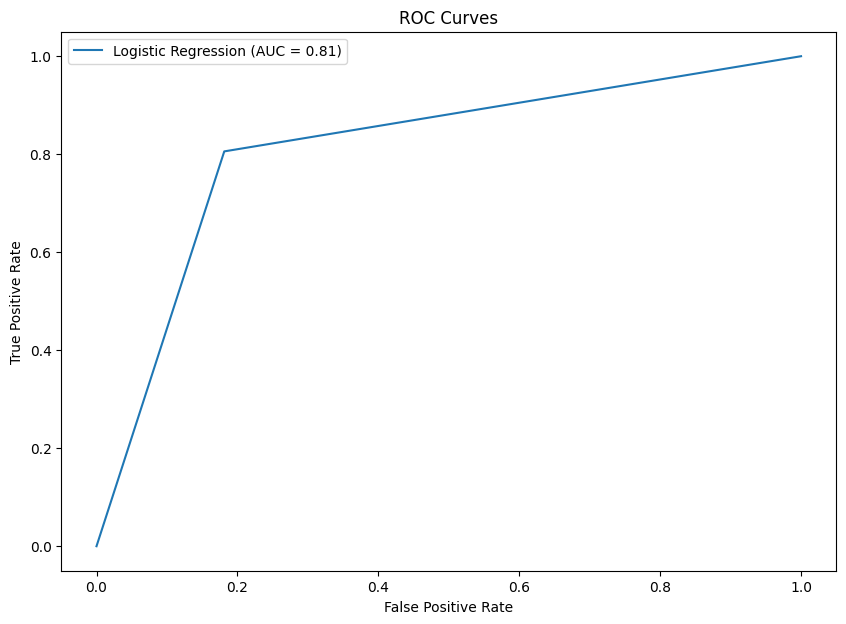

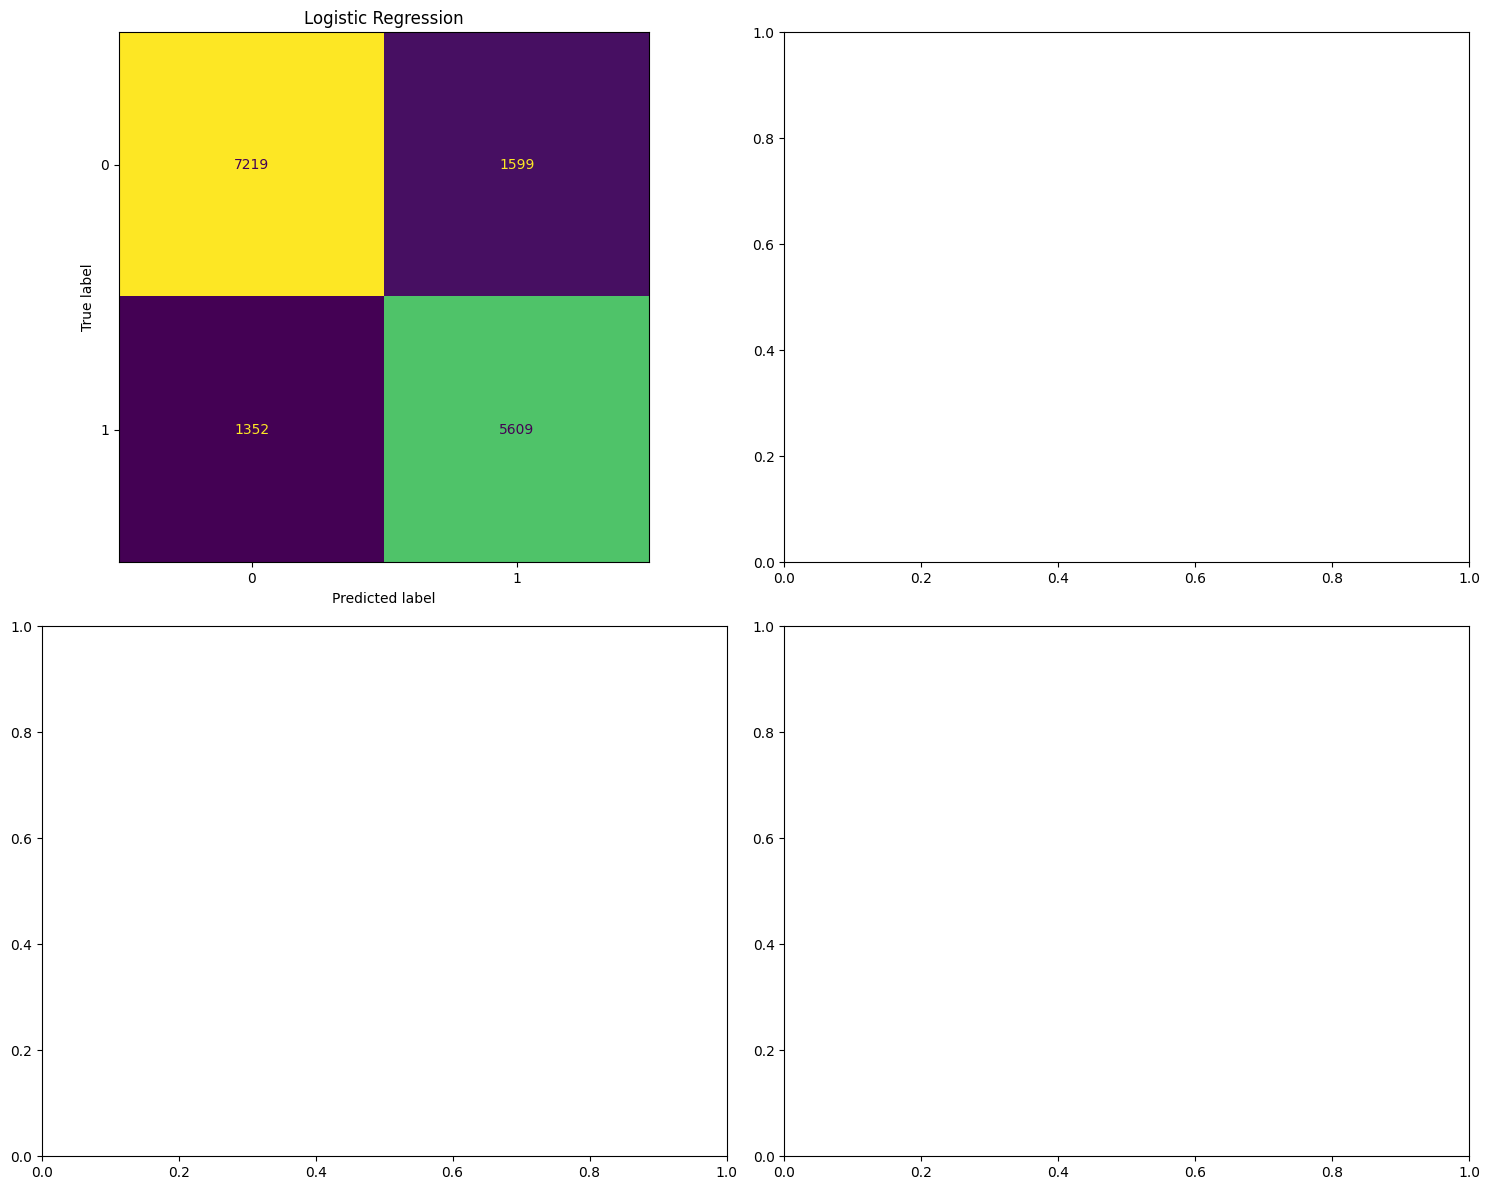

In [14]:
# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
models = [y_pred_logistic]
titles = ['Logistic Regression']
y_tests = [y_test]

for ax, model_pred, y_true, title in zip(axes.ravel(), models, y_tests, titles):
    cm = confusion_matrix(y_true, model_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
# Load the neural network models
best_conv_model = load_model('../lib/models/NeuralNetworks/conv_two_94.keras')
best_fnn_model = load_model('../lib/models/NeuralNetworks/fnn_three_hidden_57.keras')
best_lstm_model = load_model('../lib/models/NeuralNetworks/lstm_three_97.keras')

In [ ]:
# Predict with logistic regression model
y_pred_logistic = logistic_regression_model.predict(X_test)

# Convert predictions to binary (0 or 1) for logistic regression model
y_pred_logistic = (y_pred_logistic > 0.5).astype(int)

# Predict with neural network models
y_pred_conv = np.round(best_conv_model.predict(X_test_scaled)).astype(int).ravel()

# Predict with LSTM model
y_pred_lstm = np.round(best_lstm_model.predict(X_test_scaled)).astype(int).ravel()


In [ ]:
# Ensure FNN input shape matches expected input shape
X_test_fnn = X_test_scaled
if len(best_fnn_model.input_shape) == 2 and best_fnn_model.input_shape[-1] != X_test_scaled.shape[1]:
    # Adjust the number of features to match the model's expected input
    X_test_fnn = X_test_scaled[:, :best_fnn_model.input_shape[-1]]

# Predict with FNN model
y_pred_fnn = np.round(best_fnn_model.predict(X_test_fnn)).astype(int).ravel()

In [ ]:
# Ensure that y_test and y_pred arrays have the same length
y_pred_fnn = y_test[:len(y_test)]
y_test_conv = y_test[:len(y_pred_conv)]
y_pred_lstm = y_test[:len(y_test)]

In [ ]:
# Logistic Regression metrics
f1_logistic, precision_logistic, recall_logistic, rmse_logistic, fpr_logistic, tpr_logistic, auc_logistic = calculate_metrics(y_test, y_pred_logistic)

# Neural Network metrics
f1_conv, precision_conv, recall_conv, rmse_conv, fpr_conv, tpr_conv, auc_conv = calculate_metrics(y_test_conv, y_pred_conv)
f1_fnn, precision_fnn, recall_fnn, rmse_fnn, fpr_fnn, tpr_fnn, auc_fnn = calculate_metrics(y_test, y_pred_fnn)
f1_lstm, precision_lstm, recall_lstm, rmse_lstm, fpr_lstm, tpr_lstm, auc_lstm = calculate_metrics(y_test, y_pred_lstm)

In [ ]:
# Display metrics comparison
print("Logistic Regression: F1 Score =", f1_logistic, "Precision =", precision_logistic, "Recall =", recall_logistic, "RMSE =", rmse_logistic, "AUC =", auc_logistic)
print("Convolutional Neural Network: F1 Score =", f1_conv, "Precision =", precision_conv, "Recall =", recall_conv, "RMSE =", rmse_conv, "AUC =", auc_conv)
print("Fully Connected Neural Network: F1 Score =", f1_fnn, "Precision =", precision_fnn, "Recall =", recall_fnn, "RMSE =", rmse_fnn, "AUC =", auc_fnn)
print("LSTM Neural Network: F1 Score =", f1_lstm, "Precision =", precision_lstm, "Recall =", recall_lstm, "RMSE =", rmse_lstm, "AUC =", auc_lstm)


In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot(fpr_conv, tpr_conv, label=f'Convolutional NN (AUC = {auc_conv:.2f})')
plt.plot(fpr_fnn, tpr_fnn, label=f'Fully Connected NN (AUC = {auc_fnn:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM NN (AUC = {auc_lstm:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
models = [y_pred_logistic, y_pred_conv, y_pred_fnn, y_pred_lstm]
titles = ['Logistic Regression', 'Convolutional Neural Network', 'Fully Connected Neural Network', 'LSTM Neural Network']
y_tests = [y_test, y_test_conv, y_pred_fnn, y_pred_lstm]

for ax, model_pred, y_true, title in zip(axes.ravel(), models, y_tests, titles):
    cm = confusion_matrix(y_true, model_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)

plt.tight_layout()
plt.show()